#Check GPU

In [ ]:
%cd /content/drive/MyDrive/Programming/Computer Vision/Team/Mid-Term Report

/content/drive/MyDrive/Programming/Computer Vision/Team/Mid-Term Report


In [ ]:
!nvidia-smi

Sat Oct 23 15:20:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Import packages

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from translate import translate

import warnings
warnings.filterwarnings('ignore')

#Data preprocessing

In [ ]:
from translate import translate


In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/animals10'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir,x),data_transforms[x])
                    for x in ['train','val','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,shuffle=True,num_workers=16)
                for x in ['train','val','test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val','test']}
class_names = [translate[x] for x in image_datasets['train'].classes]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


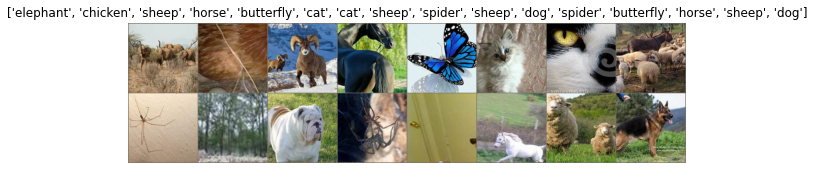

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(10,5))
imshow(out, title=[class_names[x] for x in classes])

#Train function

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  losses = {'train': [], 'val': []}
  accuracies = {'train': [], 'val': []}
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch,num_epochs - 1 ))
    print('-' * 10)

    for phase in ['train','val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()
      
      running_loss = 0.0
      running_corrects = 0

      for inputs,labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        with torch.set_grad_enabled(phase == 'train'):
          outputs = model(inputs)
          _, preds = torch.max(outputs,1)
          loss = criterion(outputs, labels)

          if phase == 'train':
            loss.backward()
            optimizer.step()

        running_loss += loss.item()* inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

      if phase == 'train':
        scheduler.step()

      epoch_loss = running_loss / dataset_sizes[phase]
      epoch_acc = running_corrects.double() / dataset_sizes[phase]

      losses[phase].append(epoch_loss)
      accuracies[phase].append(epoch_acc)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since

  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)

  return model, losses, accuracies

#Define model

##Alexnet

In [ ]:
model_alexnet = torchvision.models.alexnet(pretrained=True)
model_alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

##Freeze and reconstructing last layer

In [ ]:
for param in model_alexnet.parameters():
  param.requires_grad = False

num_classes = len(class_names)
num_ftrs = model_alexnet.classifier[-1].in_features
model_alexnet.classifier[-1] = nn.Linear(num_ftrs,num_classes)

model_alexnet.eval()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

##Train as feature extractor

In [ ]:
model_alexnet = model_alexnet.to(device)

criterion = nn.MultiMarginLoss()
optimizer = optim.SGD(model_alexnet.classifier[6].parameters(), lr = 0.001, momentum= 0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma = 0.1)

###Traning loop

In [ ]:
model_alexnet, losses, accuracies = train_model(model_alexnet, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1708 Acc: 0.7097
val Loss: 0.0486 Acc: 0.8870

Epoch 1/24
----------
train Loss: 0.1020 Acc: 0.7870
val Loss: 0.0436 Acc: 0.8910

Epoch 2/24
----------
train Loss: 0.0919 Acc: 0.8097
val Loss: 0.0428 Acc: 0.9010

Epoch 3/24
----------
train Loss: 0.0848 Acc: 0.8167
val Loss: 0.0401 Acc: 0.9120

Epoch 4/24
----------
train Loss: 0.0823 Acc: 0.8287
val Loss: 0.0409 Acc: 0.8980

Epoch 5/24
----------
train Loss: 0.0693 Acc: 0.8475
val Loss: 0.0394 Acc: 0.9050

Epoch 6/24
----------
train Loss: 0.0716 Acc: 0.8420
val Loss: 0.0423 Acc: 0.9060

Epoch 7/24
----------
train Loss: 0.0680 Acc: 0.8468
val Loss: 0.0389 Acc: 0.9120

Epoch 8/24
----------
train Loss: 0.0620 Acc: 0.8642
val Loss: 0.0389 Acc: 0.9100

Epoch 9/24
----------
train Loss: 0.0607 Acc: 0.8578
val Loss: 0.0382 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.0637 Acc: 0.8638
val Loss: 0.0385 Acc: 0.9120

Epoch 11/24
----------
train Loss: 0.0608 Acc: 0.8620
val Loss: 0.0372 Acc: 0.9140

Ep

###Visualizing metrics

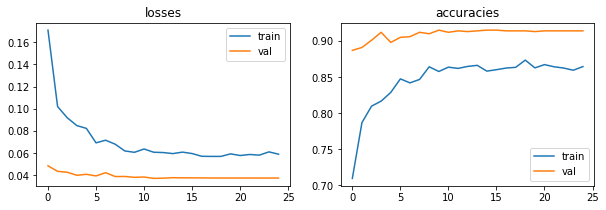

In [ ]:
plt.figure(figsize=(10,3))
ax = plt.subplot(1,2,1)
ax.plot(losses['train'],label = 'train')
ax.plot(losses['val'], label ='val')
ax.legend()
ax.set_title('losses')
bx = plt.subplot(1,2,2)
bx.plot(accuracies['train'],label = 'train')
bx.plot(accuracies['val'], label ='val')
bx.legend()
bx.set_title('accuracies')
plt.show()

#Visualizing predictions

In [ ]:
def visualize_model(model, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    return

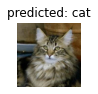

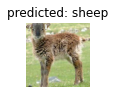

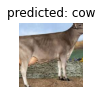

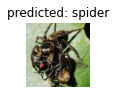

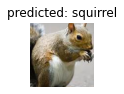

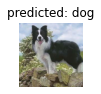

In [ ]:
visualize_model(model_alexnet,6)

plt.show()

#Final test

In [ ]:
def predict(model):
  since = time.time()

  all_predictions = []
  all_labels = []

  model.eval()

  for inputs,labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      _, preds = torch.max(outputs,1)
      all_predictions += list(preds.cpu().numpy())
      all_labels += list(labels.cpu().numpy())

  time_elapsed = time.time() - since

  print('Predicting complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

  return all_predictions, all_labels

In [ ]:
pred, labels = predict(model_alexnet)

Predicting complete in 1m 24s


In [ ]:
from sklearn.metrics import confusion_matrix, f1_score,recall_score,precision_score,accuracy_score

print('Accuracy: ', accuracy_score(pred,labels))
print('Recall: ',recall_score(pred, labels,average='micro'))
print('Precision: ',precision_score(pred, labels,average='micro'))
print('F1: ',f1_score(pred, labels,average='micro'))

Accuracy:  0.8985
Recall:  0.8985
Precision:  0.8985
F1:  0.8985
